# Distinguishing muffins and Chihuahuas with NNs

The aim of this project is to train a neural network for the binary classification of muffins and Chihuahuas based on the images contained in the relative [Kaggle dataset](https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification).

# Setup

In [81]:
import importlib
import pip

def import_or_install(package_name, alias=None):
    try:
        imported_package = importlib.import_module(package_name)
        if alias:
            globals()[alias] = imported_package
        print(f"{package_name} is already installed.")
    except ImportError:
        print(f"{package_name} is not installed. Installing...")
        pip.install(package_name)
        if alias:
            globals()[alias] = importlib.import_module(package_name)
        print(f"{package_name} has been installed.")

We import the dataset from Kaggle, using a token.

In [82]:
import os

os.environ['KAGGLE_USERNAME'] = "luciaannamellini"
os.environ['KAGGLE_KEY'] = "c209fcf223ecdd6be8fd373196354f4b"

import_or_install("kaggle")

from kaggle.api.kaggle_api_extended import KaggleApi

FOLDERNAME = "muffin-vs-chihuahua-image-classification"
PATH = "./"

api = KaggleApi()
api.authenticate()
api.dataset_download_files("samuelcortinhas/muffin-vs-chihuahua-image-classification", PATH)

kaggle is already installed.


In [83]:
import zipfile

with zipfile.ZipFile(PATH + FOLDERNAME + ".zip", 'r') as zip_ref:
    zip_ref.extractall(FOLDERNAME)
os.remove(PATH + FOLDERNAME +".zip")

If already present we import, or otherwise we install, the `tensorflow`package. Above all functionalities we will be using the `keras` module to construct the desired neural network for this project.

In [84]:
import_or_install("tensorflow","tf")

tensorflow is already installed.


# Data pre-processing

Before proceeding we remove badly encoded images.

In [85]:
from PIL import Image
def remove_badly_encoded_images(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.JPG'):
            try:
                img = Image.open(directory+filename)  # open the image file
                img.verify()  # verify that it is, in fact an image
                img.close()
            except (IOError, SyntaxError):
                os.remove(directory+filename)

deleted = remove_badly_encoded_images(PATH + FOLDERNAME + "/")
print("Deleted images:",deleted)

Deleted images: None


We begin by subdividing the dataset into training and test set. This partition is provided by the Kaggle dataset itself, with $\frac{1}{5}$ of the images assigned to the test set. 

We also infer the binary labels from the layout of the dataset. Specifically the labels are assigned as follows:
\begin{equation*}
    \begin{cases}
        0  & \text{chihuahua} \\
        1  & \text{muffin}
    \end{cases}
\end{equation*}

In [100]:
def create_dataset(foldername):
    dataset_path = os.path.join(PATH, FOLDERNAME, foldername)
    return tf.keras.utils.image_dataset_from_directory(dataset_path, labels = "inferred")

print("Training set:")
train_ds = create_dataset("train")
print("Test set")
test_ds = create_dataset("test")   

Found 5917 files belonging to 2 classes.


Let's give a look at a small sample of pictures with the relative annotations.

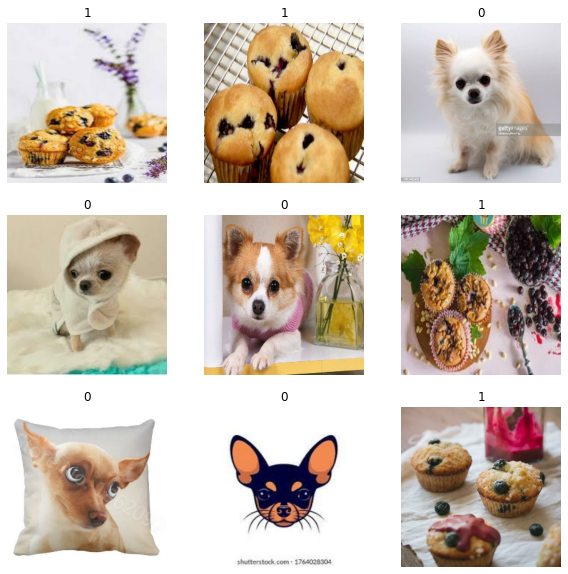

In [87]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Before diving into the actual pre-processing of the data we prepare a function that produces realistic variations of the images in the dataset. This data augmentation step is useful to make a small dataset more expressive by introducing random changes, so counteracting overfitting.

In [88]:
from keras import layers

def data_augmentation(images, data_augmentation_layers, training = True):
    for layer in data_augmentation_layers:
        images = layer(images, training = training)
    return images

For example we may randomly flip the picture or slightly tilt it. We show here the potential results of the data augmentation function.

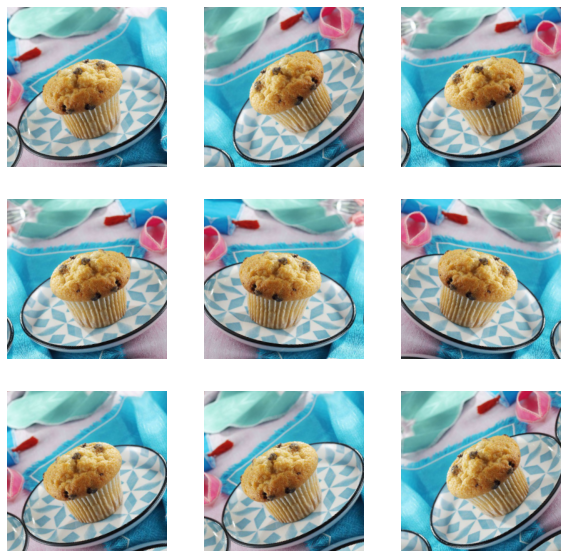

In [89]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, data_augmentation_layers, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

To make learning easer we simplify the images by:
* taking them in grayscale,
* reducing their dimensions by resizing them to the size $(64,64)$.

In [103]:
def rgb_to_grayscale(image, label):    
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label

def resize_image(image, label, target_size):
    resized_image = tf.image.resize(image, target_size)
    return resized_image, label


image_size = (64,64)

preprocess = {
    rgb_to_grayscale: lambda x, y: (tf.image.rgb_to_grayscale(x), y),
    resize_image: lambda x,y: (tf.image.resize(x, image_size))
}

for func in preprocess:
    train_ds.map(func)
    test_ds.map(func)

ValueError: Argument `func` must be a callable. Received func={<function rgb_to_grayscale at 0x000001C75E231A60>: <function <lambda> at 0x000001C75E2318B0>, <function resize_image at 0x000001C75E231550>: <function <lambda> at 0x000001C75E231670>} (of type <class 'dict'>)

Also, for the reasons stated before, we substitute each of the images in the training set with it's augmented version. Seen that this step 

In [ ]:
data_augmentation: lambda x, y: (data_augmentation(x, data_augmentation_layers, training=True), y)

train_ds.map(data_augmentation)

In [ ]:
print("Training set:")
train_ds = create_dataset("train")
print("Test set")
test_ds = create_dataset("test")

# Model construction

In [96]:
from tensorflow.keras import models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=1, batch_size=2, validation_data=test_ds)

test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


Epoch 1/10
148/148 [==============================] - 35s 227ms/step - loss: 1.9448 - accuracy: 0.6243 - val_loss: 0.6199 - val_accuracy: 0.6546
Epoch 2/10
148/148 [==============================] - 46s 303ms/step - loss: 0.5783 - accuracy: 0.7222 - val_loss: 0.5468 - val_accuracy: 0.7331
Epoch 3/10
148/148 [==============================] - 57s 373ms/step - loss: 0.4882 - accuracy: 0.7771 - val_loss: 0.5224 - val_accuracy: 0.7593
Epoch 4/10
148/148 [==============================] - 63s 413ms/step - loss: 0.4133 - accuracy: 0.8170 - val_loss: 0.4531 - val_accuracy: 0.8091
Epoch 5/10
148/148 [==============================] - 47s 306ms/step - loss: 0.3543 - accuracy: 0.8456 - val_loss: 0.6032 - val_accuracy: 0.7796
Epoch 6/10
148/148 [==============================] - 48s 315ms/step - loss: 0.2824 - accuracy: 0.8829 - val_loss: 0.5079 - val_accuracy: 0.8159
Epoch 7/10
148/148 [==============================] - 47s 307ms/step - loss: 0.1939 - accuracy: 0.9275 - val_loss: 0.5594 - val_ac

KeyboardInterrupt: 

# Experiments

# Results